In [44]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model, neighbors,datasets
from lib.helpers import *
from sklearn import svm
from lib.cross_validations_lib import *
#import peakutils
import scipy.signal as signal
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import MeanShift, estimate_bandwidth

## Utility functions


In [2]:
def split_matrix_two_blocks(y, percentage1, percentage2, seed):
    """Build k indices for k-fold."""
    if(percentage1+percentage2==1):
        num_row = len(y)
        #print(num_row)
        interval_1 = int(percentage1*num_row);
        
        np.random.seed(seed)
        indices = np.random.permutation(num_row);
        first_indices = indices[0:interval_1];
        second_indices = indices[interval_1:num_row];
        return [np.array(first_indices),np.array(second_indices)]
    else:
        print('>>>>>>>>>>>ERROR:Not valid splitting percentage')
        
        
##
## This function reutrn a list of matrices. Each matrix correspond to a question instance in which each row is a channel, and in the coloumn it develop the signal in time
## The function also manage to standardize the time length
def channels_to_vector(channels): 
    time_instances=[];
    dim=channels.shape;
    #find the length min of the signal in the specified temporal instance
    length_min=len(channels[0,1]);
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        single_length=single_measurement.shape[0]
        if(single_length<length_min):
                length_min=single_length;
    #export the signals
    for i in range (0,dim[1]):
        single_measurement=channels[0,i];
        dim1=single_measurement.shape;
        time_instance=[];
        for j  in range (0,dim1[1]):
            if(len(single_measurement[:,j])>length_min):
                single_signal=single_measurement[:,j][0:length_min]
            else:
                single_signal=single_measurement[:,j]
            #put in a list 
            time_instance.append(np.asarray(single_signal).reshape(len(single_signal),1).T);
       # create the matrix of the signals per a single time instance 
        time_instance=np.concatenate(time_instance);
        time_instances.append(time_instance);   
    return time_instances;


##
# Create the train data matrix
##
## usage
def get_feature_matrix_and_labels(channel_structure,label,features_extracted,connectivity_feature):
    list_train=[]
    list_labels=[]
    cont=0;
    index_connectivity=0;
    list_row=[]
    
    for time_instance in channel_structure:
        dim1=time_instance.shape
        #indipendent_components=extract_ICs(time_instance,n_ICA_components);
        for j  in range (0,dim1[0]):
           
            features=features_extracted[cont,:];
            list_row.append(features);
            cont=cont+1;
        """feature_dictionary["fft_max_frequencies"]=0;
        for single_component in indipendent_components:
            features=feature_extraction(single_component,feature_dictionary,features_extracted)
            list_row.append(features);"""
        list_row.append(connectivity_feature[index_connectivity,:]);
        index_connectivity=index_connectivity+1;
        labels=get_labels(1,label);
        feature_row=np.concatenate(list_row);
        list_train.append(feature_row.reshape(len(feature_row),1).T)
        list_labels.append(labels);
        list_row=[]
        
    train_TX=np.concatenate(list_train)
    labels=np.concatenate(list_labels,axis=0)
    
    return train_TX,labels.T.reshape(labels.size)


### Description
def get_labels(number, string):
    if(string=="No"):
        return np.zeros(number)    
    if(string=="Yes"):
        return np.ones(number)
    
## description
def select_features(weights,matrix,th):
    cont=0;
    i=0;
    while(cont<len(weights)):
        if(weights[cont]<th):

            mask = np.ones(matrix.shape[1], dtype=bool)
            mask[i] = False
            matrix=matrix[:,mask]
        else:
            i=i+1;
        cont=cont+1;
    return matrix

# EEG feature loading
Import data from previous analysis

In [4]:
#Import data from mat files
yes_EEG_contents = sio.loadmat('EEGyes.mat')
no_EEG_contents = sio.loadmat('EEGno.mat')

channels_no_EEG=no_EEG_contents["EEGno"]
channels_yes_EEG=yes_EEG_contents["EEGyes"]

#Features Loading
features_extracted_yes   = sio.loadmat('FeaturesYes.mat')['FeaturesYes']
features_extracted_no    = sio.loadmat('FeaturesNO.mat')['FeaturesNo']
connectivity_feature_yes = sio.loadmat('ConnectivityFeaturesYes.mat')['ConnectivityFeaturesYes']
connectivity_feature_no  = sio.loadmat('ConnectivityFeaturesNo.mat')['ConnectivityFeaturesNo']

channels_structure_yes_EEG = channels_to_vector(channels_yes_EEG)
channels_structure_no_EEG  = channels_to_vector(channels_no_EEG)

##Structuring of the data:
#the code below create the train matrix with respect to the signal given in "channel_structure" but using the features contained in "features_extracted*" and in "connettivity_feature*".
feature_dataset_yes_EEG, EEG_yes_labels = get_feature_matrix_and_labels(channels_structure_yes_EEG,"Yes",features_extracted_yes,connectivity_feature_yes);

feature_dataset_no_EEG, EEG_no_labels = get_feature_matrix_and_labels(channels_structure_no_EEG,"No",features_extracted_no,connectivity_feature_no);

#Merge the labeled data
feature_dataset_full = np.concatenate((feature_dataset_yes_EEG, feature_dataset_no_EEG), axis=0 )
labels = np.concatenate((EEG_yes_labels,EEG_no_labels), axis=0)


print("The dataset have shape:")
print(feature_dataset_full.shape)

The dataset have shape:
(60, 386)


## PCA trial
andato male (forse lo togliamo)

In [31]:
# PCA on features
n = 100
pca = PCA(n_components=n)
pca.fit(feature_dataset_full)

print(pca.explained_variance_ratio_.cumsum())
feature_dataset_full_pca = pca.transform(feature_dataset_full)
feature_dataset_full_pca.shape

[0.52179653 0.67975771 0.79265547 0.87288803 0.92288719 0.96551415
 0.97496275 0.98143919 0.98613603 0.98935557 0.99239809 0.99458724
 0.99546642 0.99632709 0.99692657 0.9973799  0.9978044  0.99809817
 0.99833507 0.99855122 0.99872918 0.99888793 0.99901421 0.99913531
 0.99923817 0.99933099 0.99940594 0.9994768  0.99953695 0.99959515
 0.99964759 0.99969437 0.99973494 0.99976915 0.99980044 0.9998267
 0.99984936 0.9998694  0.99988748 0.9999037  0.99991777 0.99992992
 0.99994088 0.9999496  0.99995692 0.99996326 0.99996902 0.99997455
 0.99997933 0.99998328 0.99998677 0.99998953 0.99999176 0.99999381
 0.99999557 0.99999703 0.9999982  0.99999924 1.         1.        ]


(60, 60)

In [9]:
C_parameters= np.logspace(-6, 3, 100)
k_fold = 5 # number of k sub-folders to divide the set
seed = 1
max_iters = 100
kernel_types=['linear', 'rbf', 'sigmoid']

best_C, best_kernel_type, best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_SVM(labels, feature_dataset_full, C_parameters, kernel_types, k_fold, seed, max_iters)

--- Fold 0 ---
>> Penalty parameter C 1e-06 <<
>> Type of Kernel  linear <<
0.3333333333333333 0.6041666666666666
>> Type of Kernel  rbf <<
0.25 0.5625
>> Type of Kernel  sigmoid <<
0.25 0.5625
>> Penalty parameter C 1.232846739442066e-06 <<
>> Type of Kernel  linear <<
0.3333333333333333 0.5833333333333334
>> Type of Kernel  rbf <<
0.25 0.5625
>> Type of Kernel  sigmoid <<
0.25 0.5625
>> Penalty parameter C 1.519911082952933e-06 <<
>> Type of Kernel  linear <<
0.4166666666666667 0.6041666666666666
>> Type of Kernel  rbf <<
0.25 0.5625
>> Type of Kernel  sigmoid <<
0.25 0.5625
>> Penalty parameter C 1.873817422860383e-06 <<
>> Type of Kernel  linear <<
0.4166666666666667 0.7083333333333334
>> Type of Kernel  rbf <<
0.25 0.5625
>> Type of Kernel  sigmoid <<
0.25 0.5625
>> Penalty parameter C 2.310129700083158e-06 <<
>> Type of Kernel  linear <<
0.4166666666666667 0.7083333333333334
>> Type of Kernel  rbf <<
0.25 0.5625
>> Type of Kernel  sigmoid <<
0.25 0.5625
>> Penalty parameter C 2.8

In [45]:
C_param_sophisticated = np.linspace(1e-5,1e-4,1000)
kernel_types_reasonable = ['linear']
k_fold = 5
max_iters = 100

best_C, best_kernel_type, best_accuracy_test, corresponding_accuracy_train = \
        cross_validation_SVM(labels, feature_dataset_full, C_param_sophisticated, kernel_types_reasonable, k_fold, seed, max_iters)

--- Fold 0 ---
>> Penalty parameter C 1e-05 <<
>> Type of Kernel  linear <<
0.6666666666666666 0.8958333333333334
>> Penalty parameter C 1.0090090090090092e-05 <<
>> Type of Kernel  linear <<
0.6666666666666666 0.8958333333333334
>> Penalty parameter C 1.0180180180180181e-05 <<
>> Type of Kernel  linear <<
0.6666666666666666 0.8958333333333334
>> Penalty parameter C 1.0270270270270272e-05 <<
>> Type of Kernel  linear <<
0.6666666666666666 0.8958333333333334
>> Penalty parameter C 1.0360360360360361e-05 <<
>> Type of Kernel  linear <<
0.6666666666666666 0.8958333333333334
>> Penalty parameter C 1.0450450450450452e-05 <<
>> Type of Kernel  linear <<
0.6666666666666666 0.8958333333333334
>> Penalty parameter C 1.0540540540540541e-05 <<
>> Type of Kernel  linear <<
0.6666666666666666 0.8958333333333334
>> Penalty parameter C 1.0630630630630632e-05 <<
>> Type of Kernel  linear <<
0.6666666666666666 0.8958333333333334
>> Penalty parameter C 1.0720720720720721e-05 <<
>> Type of Kernel  linear

In [46]:
from sklearn import svm

def classification_SVM_experiments(X, Y, best_C_input, best_kernel_type, fraction_train_test, num_experiments):
    
    best_C=best_C_input
    seed=range(num_experiments)
    svm_total_acc_test  = []
    svm_total_acc_train = [] 
    best_kernel_type=best_kernel_type
    dataset_length=X.shape[0];
    
    
    for single_seed in seed:
        [i1,i2]=split_matrix_two_blocks(X, fraction_train_test, 1-fraction_train_test,single_seed)
        
        train=X[i1,:]
        labels_train=Y[i1]
        
        test= X[i2,:]
        labels_test=Y[i2]

        #SVM classifier definition
        clf = svm.SVC(C=best_C, cache_size=200, class_weight=None, coef0=0.0,
                decision_function_shape='ovr', degree=3, gamma='auto', kernel=best_kernel_type,
                max_iter=-1, probability=False, random_state=None, shrinking=True,
                tol=0.001, verbose=False)
        #SVM fit on train data
        clf.fit(train, labels_train)  
        
        
        #Accuracy on test
        predicted_labels_test = clf.predict(test)
        SVM_accuracy_test = get_accuracy(predicted_labels_test, labels_test)
        svm_total_acc_test.append(SVM_accuracy_test)
        
        
        #Accuracy on train
        predicted_labels_train = clf.predict(train)
        SVM_accuracy_train = get_accuracy(predicted_labels_train, labels_train)
        svm_total_acc_train.append(SVM_accuracy_train)
        #print("Accuracy: "+ str(SVM_accuracy) + "; iteration  " + str(single_seed) )
    return svm_total_acc_test, svm_total_acc_train
    #return [np.mean(svm_total_acc_test), np.std(svm_total_acc_test), np.mean(svm_total_acc_train), np.std(svm_total_acc_train)]

In [64]:
num_experiment = 500

fracs = np.linspace(0.2,0.9,20)
accuracy_test_mean  = []
accuracy_test_std   = []
accuracy_train_mean = []
accuracy_train_std  = []

for frac_tr_te in fracs:
    acc_test, acc_train = classification_SVM_experiments(feature_dataset_full, labels, best_C, best_kernel_type, frac_tr_te, num_experiment)
    #saving of metrics of interest
    accuracy_test_mean.append(np.mean(acc_test))
    accuracy_test_std.append(np.std(acc_test))
    accuracy_train_mean.append(np.mean(acc_train))
    accuracy_train_std.append(np.std(acc_train))
    

#print(np.mean(acc_test))
#print(np.mean(acc_train))

## Results plotting
wow

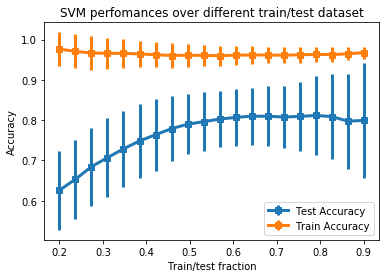

In [87]:
#plt.plot(fracs, accuracy_test_mean)
#plt.plot(fracs, accuracy_train_mean
plt.errorbar(fracs, accuracy_test_mean, yerr=accuracy_test_std, label="Error bars plot", fmt="s-",  linewidth=3)
plt.errorbar(fracs, accuracy_train_mean, yerr=accuracy_train_std, label="Error bars plot", fmt="s-",  linewidth=3)
plt.title('SVM perfomances over different train/test dataset')
plt.ylabel('Accuracy')
plt.xlabel('Train/test fraction')
plt.legend(['Test Accuracy', 'Train Accuracy'], loc=4)
plt.savefig('train_test_acc', format='pdf')
plt.show()

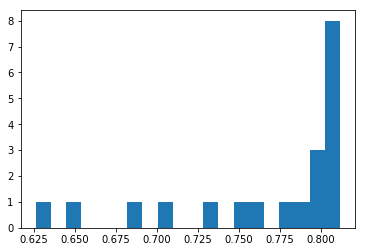

In [75]:
plt.hist(accuracy_test_mean, bins=20, alpha=1)
plt.show()

In [55]:
fracs = np.linspace(0.4,0.9,10)
plt.plot(fracs,accuracy)
plt.show()

NameError: name 'accuracy' is not defined